
### Decision Trees 

### What if our data looked like this? 

![](complex.png)

* We could develop complicated models (e.g., deep learning neural networks to solve the problem of separating the two classes of data)
* It would be desirable to build models of data that allow for complex decision boundaries while maintaining intepretability. 

### What is a decision tree?  

At its heart, a decision tree is a flow chart. 

* Formally, a decision tree model is one in which the final outcome of the model is based on a series of comparisons of the values of predictors against threshold values.
* In a graphical representation (flow chart),
    * the internal nodes of the tree represent attribute testing.
    * branching in the next level is determined by attribute value.
    * the node before the branch is a parent, the nodes formed by the branching are the children
    * terminal leaf nodes represent class assignments - this is where the decision is made and you read out the decision! 

![](orangelemon.png)



### Given a training set, learning a decision tree model for binary classification means:
* producing an optimal partition of the feature space with axis-aligned linear boundaries (maximally interpretable!),
* each region is predicted to have a class label based on the largest count of the training points in that region. 

### Entropy (aka Uncertainty)

Say that we have a coin, and each coin fliip is an observation producing the data $X = \{x_i, i = 1 \dots n\}$. The coin has probability $p_i$ to yield heads. 

 Let $H(X)$ represent the entropy of $X$:

$$ H(X) = -\large \sum_{i=1}^{n} p_i \times log(p_i) $$

The base of the algorithm is arbitrary.  In Information theory, base 2 logarithms $log_2$ are usually used, and the units of entropy are bits of information.  In machine learning, natural logarithms $ln$ are used and the units are nats.

The entropy reflects the uncertainty in X. In fact, it's the highest possible, when  it's truly a 50/50 chance of either Heads or Tails, i.e. $p_i = 0.5$


![](coin_flip.png)

If we had a cheating coin, whereby it was guaranteed to always be a head (or a tail), then our entropy would be 0, as there is no **uncertainty** about its outcome. Again, this term, entropy, predates decision trees and has vast applications. Alright, so we can see what entropy is measuring (the uncertainty), but how was it actually calculated?

Entropy factors in _all_ possible values/classes of a random variable

### Worked Example

Let's say that we have a small, 14-observation dataset that concerns if we will play tennis on a given day or not (Play Tennis will be our output $Y$), based on 4 features of the current weather:

![](play_tennis_dataset.png)


Completely independent of the features, we can calculate the overall entropy of playing tennis, Entropy for (9+, 5-) examples =

$$  H(X) = -1 * (P(playtennis=yes) \times log_2(P(playtennis=yes)) + P(playtennis=no) \times log_2(P(playtennis=no))) $$
$$  H(X) = -\frac{9}{14}log_2(\frac{9}{14}) - \frac{5}{14}log_2(\frac{5}{14}) = 0.94 $$

    
**0.94** is pretty horrible, as it's close to 1, which is the worst possible value. This means that a priori, if we use no features, it's hard to predict if we will play tennis or not. There's a lot of uncertainty (aka entropy). To improve this, could we segment our data in such a way that it's more predictable if we will play tennis or not (i.e., we will have lower uncertainty... lower entropy).

Let's start with looking at the ``Wind`` feature. There are 2 possible values for the Wind attribute, **weak** or **strong.** If we were to look at the subset of data that has weak wind, we see that there are 8 data samples (6 are 'Yes' for Play Tennis, 2 have 'No' for Play Tennis). If we know that the Wind is weak, it helps inform us that there's a 6/8 (75%) chance that we will Play Tennis. Let's put this in terms of entropy:

When we look at ONLY the Wind is Weak subset of data, we have a Play Tennis entropy for (6+, 2-) examples, which calculates to:

$$ H(X) = -1 * (P(playtennis=yes) \times log_2(P(playtennis=yes)) + P(playtennis=no)\times log_2(P(play_tennis=no))) $$
$$ H(X) = -\frac{6}{8}log(\frac{6}{8}) - \frac{2}{8}log(\frac{2}{8}) = 0.811 $$

A value of 0.811 may seem sadly high, still, but our calculation was correct. If you reference the figure above that shows the entropy of a fair coin, we see that having a probability of 75% does in fact yield an entropy of 0.811, ** which is less than 0.94**.  So, knowing that the Wind is weak was helpful.  

But, We're only looking at a subset of our data though (the subset for Wind is Weak). We now need to look at the rest of our data (the subset for Wind is Strong). When the Wind is Strong, we have 6 data points: 3 have Play Tennis is Yes, and 3 are No. 
In short-hand notation, we have (3+, 3-), which is a 0.5 probability.  This is like a fair coin, which yields the maximum Entropy of 1.

We can calculate the average entropy of all of the data given knowledge of Wind as the weighted average of the entropy of each partition

$$ H(X | Wind) = \frac{8}{14} \times 0.811 + \frac{6}{14}*1 = 0.892 $$

When looking at this possible division of separating our data according to the value of Wind, the hope was that we'd have very low entropy in each subset of data. Imagine if the Wind attribute perfectly aligned with Playing Tennis or not (the values were identical). In that case, we would have an Entropy of 0 (no uncertainty), and thus, it would be INCREDIBLY useful to predict playing tennis or not based on the Wind attribute (it would tell us the exact answer).

We saw that the Wind attribute didn't yield an entropy of 0; its two classes (weak and strong) had an entropy of 0.811 and 1, respectively and hte average entripy is 0.892.  So, knowing the wind reduced the uncertainty, but not by a lot. 

We can calculate ``Information Gain`` associated with Feature S as 

$$Gain(S) = H(X) - H(X/S)$$

In our example, 

$$ Gain(Wind) = H(playtennis) - H(playtennis/Wind)= 0.94 - \frac{8}{14} \times 0.811 - \frac{6}{14} \times 1.00 = 0.048 $$

In [40]:
# imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [41]:
#Load the play_tennis data set 
tennis_df = pd.read_csv("../data/play_tennis.csv")
tennis_df.info()
tennis_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   outlook   14 non-null     object
 1   temp      14 non-null     object
 2   humidity  14 non-null     object
 3   windy     14 non-null     bool  
 4   play      14 non-null     object
dtypes: bool(1), object(4)
memory usage: 594.0+ bytes


,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [42]:
tennis_num = tennis_df
tennis_num = pd.get_dummies(tennis_num, columns=['outlook', 'temp', 'humidity', 'windy'])
tennis_num.info()
tennis_num.head()

class_names   = ['No','Yes']
feature_names = tennis_num.columns[1:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   play              14 non-null     object
 1   outlook_overcast  14 non-null     bool  
 2   outlook_rainy     14 non-null     bool  
 3   outlook_sunny     14 non-null     bool  
 4   temp_cool         14 non-null     bool  
 5   temp_hot          14 non-null     bool  
 6   temp_mild         14 non-null     bool  
 7   humidity_high     14 non-null     bool  
 8   humidity_normal   14 non-null     bool  
 9   windy_False       14 non-null     bool  
 10  windy_True        14 non-null     bool  
dtypes: bool(10), object(1)
memory usage: 384.0+ bytes


In [43]:
# separate our data into X and Y portions
x_train = tennis_num.iloc[:, tennis_num.columns != 'play'].values
y_train = tennis_num['play'].values

We can build a DecisionTree classifier using default values follows:

In [44]:
dt = DecisionTreeClassifier(criterion = 'entropy').fit(x_train, y_train)

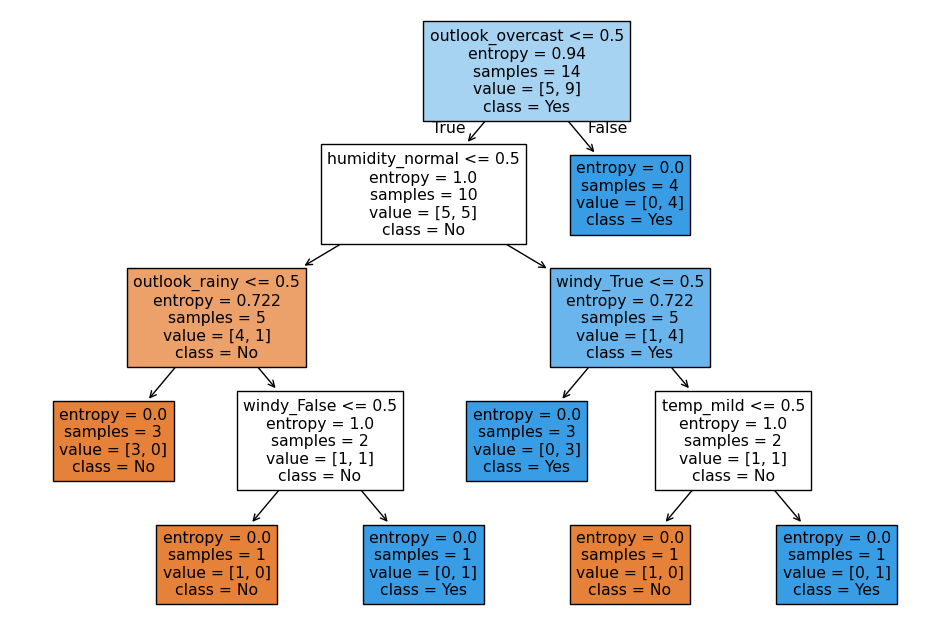

In [45]:
plt.figure(figsize=(12,8))
tree_vis = plot_tree(dt, filled=True, feature_names = feature_names, class_names = class_names)

* The goal here is to make splits that will create regions of the feature space with as little as possible uncertainty  
* By default, DecisionTreeClassifier uses a gini coefficient for classification, and you have to tell it to use entropy. 
* The goal of a decision tree is to partition the data into pure classes with entropy = 0. 
* This is obviously an overfit model. 



### Let's revisit the PIMA Indians diabetes data.

In [46]:
# load in the data
pima = pd.read_csv("../data/diabetes_nan.csv")
pima = pima.dropna()
pima.info()
cols = pima.columns
diabetes = pima['Outcome']
predictors = pima[cols[1:8]]


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               392 non-null    int64  
 1   Glucose                   392 non-null    float64
 2   BloodPressure             392 non-null    float64
 3   SkinThickness             392 non-null    float64
 4   Insulin                   392 non-null    float64
 5   BMI                       392 non-null    float64
 6   DiabetesPedigreeFunction  392 non-null    float64
 7   Age                       392 non-null    int64  
 8   Outcome                   392 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 30.6 KB


One way I can specify parameters to prevent overfitting is to specify `max_depth` of the tree 

In [47]:
# isolate out the data we need
X             = np.array(predictors)
y             = np.array(diabetes)
class_names   = class_names=['Undiagnosed','Diabetes']
feature_names = cols[1:8]

# perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit a decision tree classifier with max_depth=2
dt_pima = DecisionTreeClassifier(max_depth=3, random_state=42, criterion = 'entropy')
#dt_pima = DecisionTreeClassifier(min_samples_split =5, random_state=42)

dt_pima.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

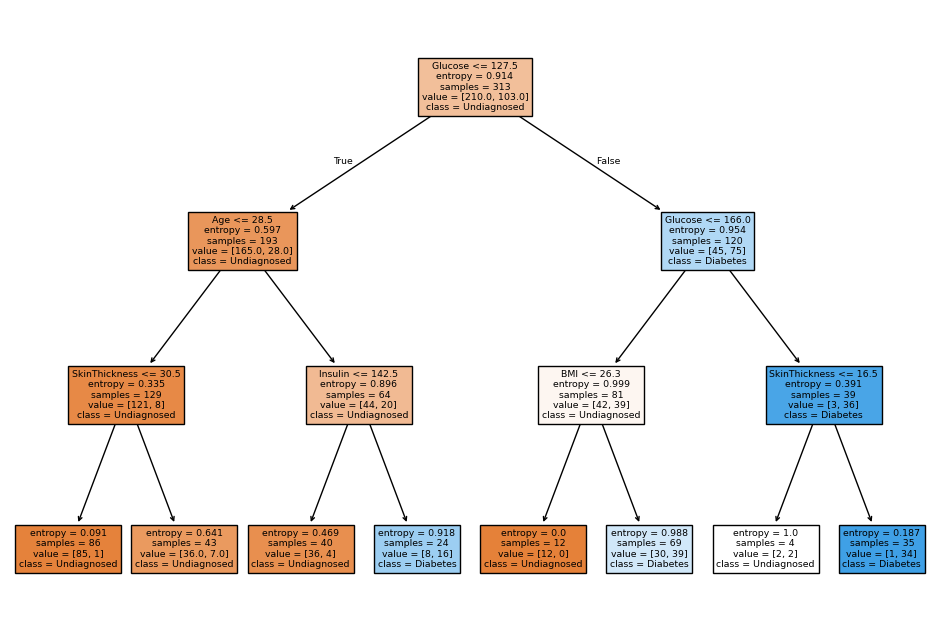

In [48]:
plt.figure(figsize = (12,8))
plot_tree(dt_pima, filled=True, feature_names = feature_names, class_names = class_names)
plt.show()

In [49]:
y_pred = dt_pima.predict(X_test)
print('accuracy score:', dt_pima.score(X_test, y_test))


accuracy score: 0.7341772151898734


In [50]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[39 13]
 [ 8 19]]


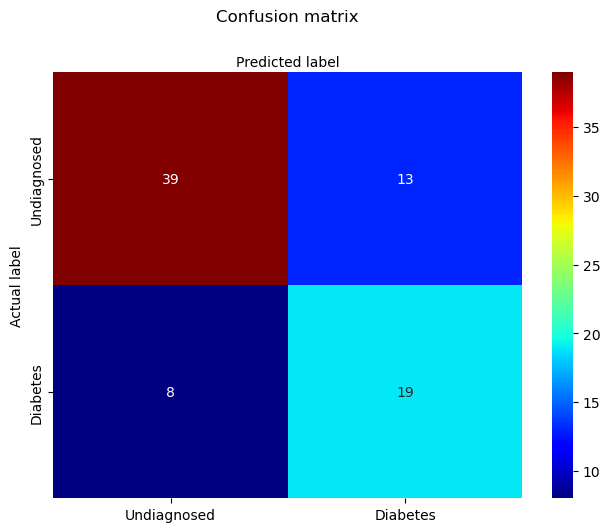

In [51]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="jet" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks+0.5, class_names)
plt.yticks(tick_marks+0.5, class_names)
plt.show()

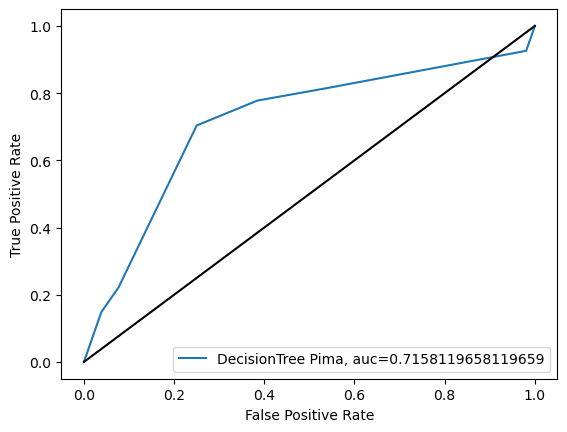

In [52]:
y_pprob = dt_pima.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pprob[:,1])
auc = roc_auc_score(y_test, y_pprob[:,1])
plt.plot(fpr,tpr,label="DecisionTree Pima, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k-')
plt.legend(loc=4)
plt.show()

### Hyperparameter

Setting the `max_depth` is choosing a **hyperparameter**.  This leads to a whole new set of questions  

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [53]:
## The right way to do this, might be to make a loop 
#for j in range(2,6)
#    dt = DecisionTreeClassifier(max_depth = j,rand_state = 43)


### Random Forest Classifier
There are two main limitations of decision trees: 
* Decision trees are greedy optimization methods. 
* Manual inspection of a whole set of models with different numbers of features is time consuming. This might be ok when we work with a small number of features. 
There are a number of approaches that have been developed to objectively select a decision tree.  I give an example of a widely used one called a Random Forest. 
The idea behind a random forest is to fit a large number of models, with some randomness

### Random Forests
Random Forest creates ensembles of independent decision trees:

    1. Train each tree on a separate random sample of the full training set
    2. For each tree, at each split, we randomly select a subset of $J^{\prime}$ predictors from the full set of predictors.
    3. From amongst the $J^{\prime}$ predictors, we select the optimal predictor and the optimal corresponding threshold for the split.
    4. The results of all the trees are then averaged together ("voting") to make the prediction.  

In [72]:
from sklearn.ensemble import RandomForestClassifier
n_trees = 200
rf_pima = RandomForestClassifier(n_estimators=n_trees,random_state = 42)
rf_pima.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [67]:
y_pred = rf_pima.predict(X_test)
print('accuracy score: ', rf_pima.score(X_test,y_test))

accuracy score:  0.759493670886076


In [68]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[45  7]
 [12 15]]


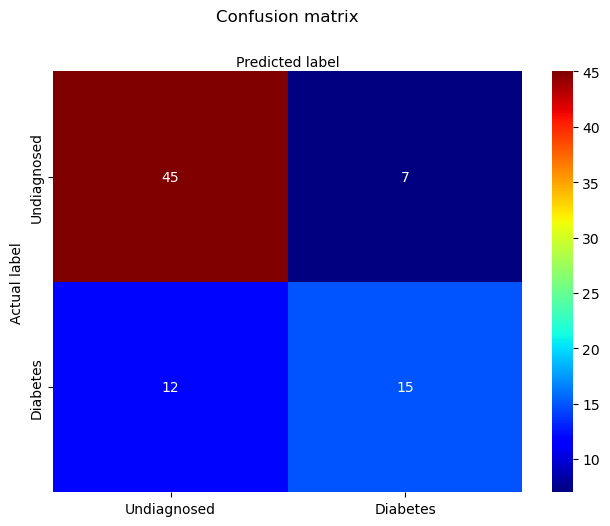

In [69]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="jet" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks+0.5, class_names)
plt.yticks(tick_marks+0.5, class_names)
plt.show()

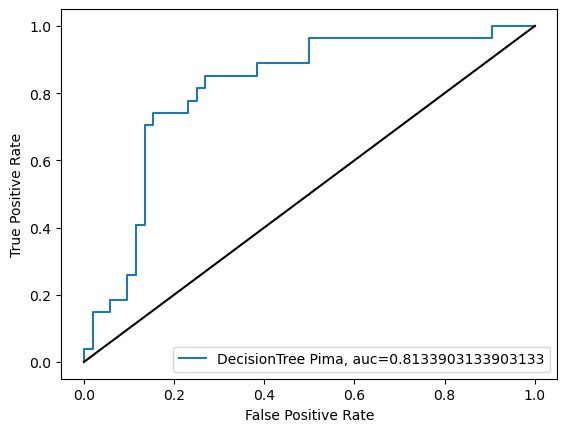

In [70]:
y_pprob = rf_pima.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pprob[:,1])
auc = roc_auc_score(y_test, y_pprob[:,1])
plt.plot(fpr,tpr,label="DecisionTree Pima, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1],[0,1],'k-')
plt.legend(loc=4)
plt.show()

* You should be able to quickly convince yourself that making a model with a lot of depth does not buy you anything. 
* The whole point is to keep the depth low and aggregate over many shallow models. 
* Wisdom of crowd type of model. 
  

### Classical  Approach to Interpretation. 
* For interpretation, the problem is I cant draw a tree now, because I used 200 trees to make this model.
* What I can do, is to investigate the importance of feature by turing it into noise. Here, we do it by permutation. 
* Measure the loss of performance relative to the original test data.  

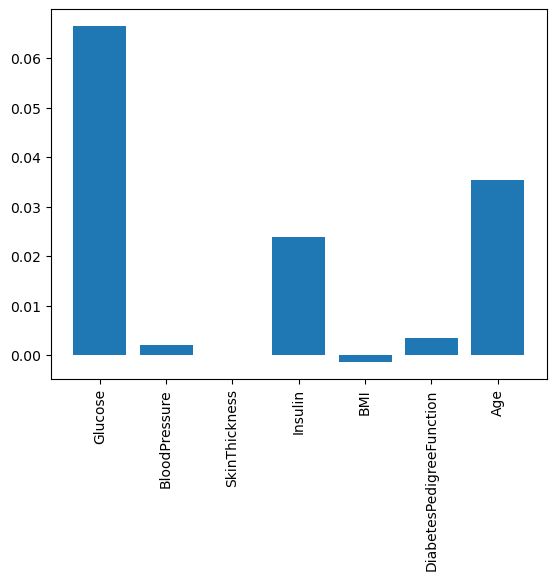

In [71]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf_pima,X_test,y_test,n_repeats = 100)
plt.bar(feature_names,result['importances_mean'])
plt.xticks(feature_names,rotation=90)
plt.show()

### Partial Dependence

Given a set of features $x_s$ and its complement $x_c$, 

$$ pd(x_s) = \int f(x_s,x_c)p(x_c)p(x_c)dx_c $$

Here $f$ is (for example) the prediction probabilty of a given sample. 
Typically we can average this over the training samples.  

In [64]:

from sklearn.inspection import partial_dependence
predictions = partial_dependence(rf_pima, X_train,features = [0],kind = 'average' )

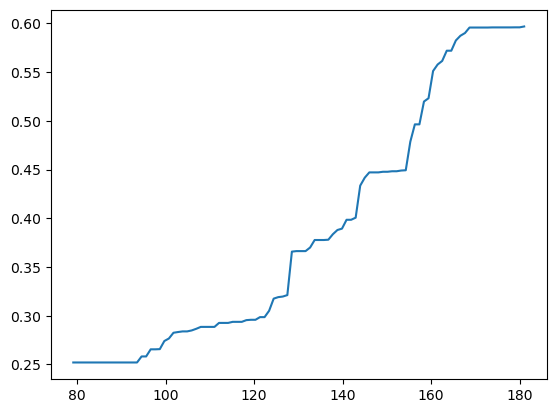

In [66]:
plt.plot(predictions['grid_values'][0],predictions['average'][0])
plt.xlabel('Glucose')
plt.ylabel('Expected Value')
plt.show()

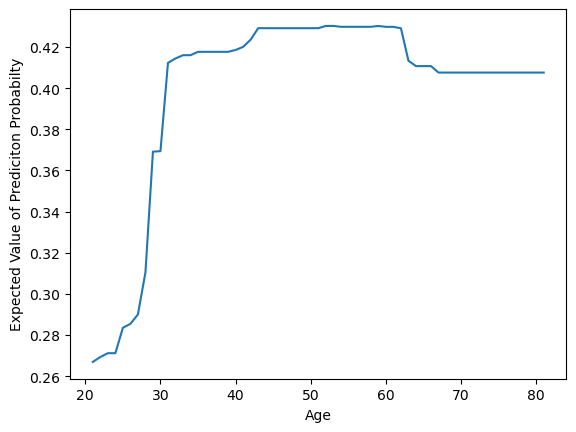

In [69]:
predictions = partial_dependence(rf_pima, X_train,features = [6],kind = 'average' )
plt.plot(predictions['grid_values'][0],predictions['average'][0])
plt.xlabel('Age')
plt.ylabel('Expected Value')
plt.show()

## The limitations of random forest

#### When can Random Forest overfit? 
- Increasing the number of trees in RF generally doesn't increase the risk of overfitting, BUT if the number of trees in the ensemble is too large then the trees in the ensemble may become correlated, and therefore increase the variance.

#### When can Random Forest fail? 

- **When we have a lot of predictors that are completely independent of the response and a few overwhelmingly influential predictor**.


Boosting Classifiers - ADABoost and XGBoost
            
            pip install xgboost

XGboost is not part of sklearn and has to be installed separately.

In [28]:
from sklearn.ensemble import AdaBoostClassifier
#The default is actually a DecisionTreeClassifier with depth 1
#Default is 50 estimators unless a perfect fit is achieved before then. 
boost_pima = AdaBoostClassifier( estimator = DecisionTreeClassifier(max_depth = 1), 
                            algorithm = 'SAMME',n_estimators=50)

# Fit on the entire data
boost_pima.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1))

In [32]:
y_pred = boost_pima.predict(X_test)
print('accuracy score: ', accuracy_score(y_test,y_pred))

accuracy score:  0.7792207792207793
